# Table of Contents
1. [Disclaimer](#Disclaimer)
2. [Imports](#Imports)
3. [Reading the collected data](#Reading-the-collected-data)
4. [Functions for CDN identification](#Functions-for-CDN-identification)
5. [CDN identification](#CDN-identification)
6. [Share of CDNs (or identified CDNs)](#Share-of-CDNs-(or-identified-CDNs))
7. [Share of CDN providers](#Share-of-CDN-providers)

# Disclaimer

The top 1000 dataset sourced from the Chrome UX report (CrUX) may contain adult content websites or websites that are not deemed trustworthy. Therefore, it is possible that these links may also appear in the requests dataset in this analysis. 

Links contained in the body text / markdown text were last checked on 27.06.2024.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
import numpy as np

# Reading the collected data

In [2]:
# read the csv file
df = pd.read_csv('requests.csv')

# show 10 random entries
df.sample(10)

,Page,Full URL,Subdomain,Domain,Suffix,IP,CNAME,ASN,ASN Description,Response Headers
42350,https://dantri.com.vn,https://fonts.googleapis.com/css?family=Archiv...,fonts,googleapis,com,142.251.36.228,NaN,15169.0,GOOGLE,"{'access-control-allow-origin': '*', 'alt-svc'..."
51486,https://as.com,https://pagead2.googlesyndication.com/pagead/g...,pagead2,googlesyndication,com,142.251.36.164,NaN,15169.0,GOOGLE,"{'alt-svc': 'h3="":443""; ma=2592000,h3-29="":443..."
35961,https://www.amazon.com.tr,https://m.media-amazon.com/images/I/61AES6+pEG...,m,media-amazon,com,NaN,c.media-amazon.com,NaN,NaN,"{'accept-ranges': 'bytes', 'access-control-all..."
12396,https://www.fmkorea.com,https://static.fmkorea.com/classes/lazy/js/scr...,static,fmkorea,com,93.184.223.182,a760.w39.akamai.net,15133.0,EDGECAST,"{'access-control-allow-origin': '*', 'cache-co..."
45439,https://jp.pornhub.com,https://ei.phncdn.com/videos/202212/08/4210515...,ei,phncdn,com,NaN,ei.phncdn.com.sds.rncdn7.com,NaN,NaN,"{'access-control-allow-origin': '*', 'cache-co..."
19880,https://www.iltalehti.fi,https://img.ilcdn.fi/_rKIIZP6x0KTZpZwv50DHTeg6...,img,ilcdn,fi,NaN,d3cdjjarcvj45p.cloudfront.net,NaN,NaN,"{'age': '4175', 'cache-control': 'max-age=3153..."
40638,https://snaptik.app,https://adsystem.pocpoc.io/js/v1/adtag.js,adsystem,pocpoc,io,104.26.14.167,NaN,13335.0,CLOUDFLARENET,"{'age': '45', 'alt-svc': 'h3="":443""; ma=86400'..."
40354,https://www.elnacional.cat,https://www.tradingview-widget.com/static/bund...,www,tradingview-widget,com,NaN,tradingview-widget.b-cdn.net,NaN,NaN,"{'access-control-allow-origin': '*', 'cache-co..."
48726,https://www.abozeb.com,https://www.abozeb.com/,www,abozeb,com,104.21.83.142,NaN,13335.0,CLOUDFLARENET,"{'age': '134573', 'alt-svc': 'h3="":443""; ma=86..."
25769,https://www.xvideos91.com,https://www.xvideos91.com/static-files/v-02405...,www,xvideos91,com,185.88.181.3,www.xvideos.com.cdn.cloudflare.net,46652.0,SERVERSTACK-ASN,"{'accept-ranges': 'bytes', 'access-control-all..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page              53940 non-null  object 
 1   Full URL          53940 non-null  object 
 2   Subdomain         49858 non-null  object 
 3   Domain            53940 non-null  object 
 4   Suffix            53561 non-null  object 
 5   IP                41805 non-null  object 
 6   CNAME             32503 non-null  object 
 7   ASN               41155 non-null  float64
 8   ASN Description   41155 non-null  object 
 9   Response Headers  53940 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.1+ MB


# Functions for CDN identification

### Check for CDNs using the http response header

Some CDNs send their own custom response header along with the requested ressource. This is used as a first step in CDN identification.

The `header_mappings` list data was collected manually. In the cases where the CDN name is not directly in the header, a reference to the documentation of their origin is attached. 

In [4]:
header_mappings = [
    ["x-amz-cf-id", "Amazon Cloudfront"], # https://docs.aws.amazon.com/AmazonCloudFront/latest/DeveloperGuide/RequestAndResponseBehaviorCustomOrigin.html
    ["x-azure-ref", "Azure"], # https://learn.microsoft.com/en-us/azure/frontdoor/front-door-http-headers-protocol
    ["cf-ray", "Cloudflare"], # https://developers.cloudflare.com/fundamentals/reference/http-request-headers/#cf-ray
    ["cf-cache-status", "Cloudflare"], # https://developers.cloudflare.com/cache/concepts/cache-responses/
    ["x-fastly-request-id", "Fastly"],
    ["x-served-by", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Served-By/
    ["x-cache-hits", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Cache-Hits/
    ["x-timer", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Timer/
    ["x-akamai-request-id", "Akamai"],
    ["x-cache-remote", "Akamai"], # https://techdocs.akamai.com/edge-diagnostics/docs/pragma-headers
    ["akamai-true-ttl", "Akamai"],
    ["x-true-cache-key", "Akamai"], # https://techdocs.akamai.com/edge-diagnostics/docs/pragma-headers
    ["x-goog-storage-class", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers#xgoogstorageclass
    ["x-guploader-uploadid", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers#xguploaderuploadid
    ["x-goog", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers
]


def check_headers(header):
    if header == "" or header is None:
        return
    for header_mapping in header_mappings:
        if header_mapping[0] in header.lower():
            return header_mapping[1]
    return

### Check for CDNs using the URL / CNAME

CDNs have their own URLs that they use to deliver their contents. In cases where these URLs are not obscured, they can be used to identify the CDN behind the requested ressource. This is used as a second step in CDN identification. 

In case they are obscured using a Canonical Name (CNAME) record, checking the resolved hostname can reveal the actual CDN provider. This is used as a third step in CDN identification.

The `mappings` list data was obtained from the [GitHub repository turbobytes/cdnfinder](https://github.com/turbobytes/cdnfinder/blob/master/assets/cnamechain.json), a deprecated open-source version of the now closed source [CDN Finder tool](https://www.cdnplanet.com/tools/cdnfinder/) by CDN Planet.

In [5]:
mappings = [
  [".clients.turbobytes.net", "TurboBytes"],
  [".turbobytes-cdn.com", "TurboBytes"],
  [".afxcdn.net", "afxcdn.net"],
  [".akamai.net", "Akamai"],
  [".akamaiedge.net", "Akamai"],
  [".akadns.net", "Akamai"],
  [".akamaitechnologies.com", "Akamai"],
  [".gslb.tbcache.com", "Alimama"],
  [".cloudfront.net", "Amazon Cloudfront"],
  [".anankecdn.com.br", "Ananke"],
  [".att-dsa.net", "AT&T"],
  [".azioncdn.net", "Azion"],
  [".belugacdn.com", "BelugaCDN"],
  [".bluehatnetwork.com", "Blue Hat Network"],
  [".systemcdn.net", "EdgeCast"],
  [".cachefly.net", "Cachefly"],
  [".cdn77.net", "CDN77"],
  [".cdn77.org", "CDN77"],
  [".panthercdn.com", "CDNetworks"],
  [".cdngc.net", "CDNetworks"],
  [".gccdn.net", "CDNetworks"],
  [".gccdn.cn", "CDNetworks"],
  [".cdnify.io", "CDNify"],
  [".ccgslb.com", "ChinaCache"],
  [".ccgslb.net", "ChinaCache"],
  [".c3cache.net", "ChinaCache"],
  [".chinacache.net", "ChinaCache"],
  [".c3cdn.net", "ChinaCache"],
  [".lxdns.com", "ChinaNetCenter"],
  [".speedcdns.com", "QUANTIL/ChinaNetCenter"],
  [".mwcloudcdn.com", "QUANTIL/ChinaNetCenter"],
  [".cloudflare.com", "Cloudflare"],
  [".cloudflare.net", "Cloudflare"],
  [".edgecastcdn.net", "EdgeCast"],
  [".adn.", "EdgeCast"],
  [".wac.", "EdgeCast"],
  [".wpc.", "EdgeCast"],
  [".fastly.net", "Fastly"],
  [".fastlylb.net", "Fastly"],
  [".google.", "Google"],
  ["googlesyndication.", "Google"],
  ["youtube.", "Google"],
  [".googleusercontent.com", "Google"],
  [".l.doubleclick.net", "Google"],
  ["d.gcdn.co", "G-core"],
  [".hiberniacdn.com", "Hibernia"],
  [".hwcdn.net", "Highwinds"],
  [".incapdns.net", "Incapsula"],
  [".inscname.net", "Instartlogic"],
  [".insnw.net", "Instartlogic"],
  [".internapcdn.net", "Internap"],
  [".kxcdn.com", "KeyCDN"],
  [".lswcdn.net", "LeaseWeb CDN"],
  [".footprint.net", "Level3"],
  [".llnwd.net", "Limelight"],
  [".lldns.net", "Limelight"],
  [".netdna-cdn.com", "MaxCDN"],
  [".netdna-ssl.com", "MaxCDN"],
  [".netdna.com", "MaxCDN"],
  [".stackpathdns.com", "StackPath"],
  [".mncdn.com", "Medianova"],
  [".instacontent.net", "Mirror Image"],
  [".mirror-image.net", "Mirror Image"],
  [".cap-mii.net", "Mirror Image"],
  [".rncdn1.com", "Reflected Networks"],
  [".simplecdn.net", "Simple CDN"],
  [".swiftcdn1.com", "SwiftCDN"],
  [".swiftserve.com", "SwiftServe"],
  [".gslb.taobao.com", "Taobao"],
  [".cdn.bitgravity.com", "Tata communications"],
  [".cdn.telefonica.com", "Telefonica"],
  [".vo.msecnd.net", "Windows Azure"],
  [".ay1.b.yahoo.com", "Yahoo"],
  [".yimg.", "Yahoo"],
  [".zenedge.net", "Zenedge"],
  [".b-cdn.net", "BunnyCDN"],
  [".ksyuncdn.com", "Kingsoft"]
]

def check_url(url):
    if url == "" or url is None:
        return
    for mapping in mappings:
        if mapping[0] in url.lower():
            return mapping[1]
    return

### Check for CDNs using the autonomous system number (ASN)

CDNs can be assigned to an ASN based on their IP address. This mapping takes into account the top 6 CDNs in the [2022 Web Alamanac](https://almanac.httparchive.org/en/2022/cdn#top-cdn-providers). This is used as the last step in CDN identification.

In [6]:
considered_asns = [
  ["CLOUDFLARE", "Cloudflare"],
  ["GOOGLE", "Google"],
  ["FASTLY", "Fastly"],
  ["AMAZON", "Amazon Cloudfront"],
  ["AKAMAI", "Akamai"],
  ["AUTOMATTIC", "Automattic"],
]

def check_asn(asn_description):
    if asn_description == "" or asn_description is None:
        return
    for asn in considered_asns:
        if asn[0] in asn_description:
            return asn[1]
    return

# CDN identification



In [7]:
def new_identify_cdn(row):
    # Check if CDN is identifiable via headers
    cdn_by_header = check_headers(row['Response Headers'])
    if cdn_by_header:
        row["CDN"] = cdn_by_header
        row["identified_via"] = "Response Headers"
        return pd.Series(row)
    
    # Check if CDN is identifiable via URL
    cdn_by_url = check_url(row['Full URL'])
    if cdn_by_url:
        row["CDN"] = cdn_by_url
        row["identified_via"] = "URL"
        return pd.Series(row)
    
    # Check if CDN is identifiable via CNAME
    cdn_by_cname = check_url(str(row['CNAME']))
    if cdn_by_cname:
        row["CDN"] = cdn_by_cname
        row["identified_via"] = "CNAME"
        return pd.Series(row)
        
    # Check if CDN is identifiable via ASN
    cdn_by_asn = check_asn(str(row['ASN Description']))
    if cdn_by_asn:
        row["CDN"] = cdn_by_asn
        row["identified_via"] = "ASN"
        return pd.Series(row)
        
    row["identified_via"] = "Not a CDN / not identified"
    return pd.Series(row)

In [8]:
df = df.apply(new_identify_cdn, axis=1)

In [9]:
df.sample(10)

,ASN,ASN Description,CDN,CNAME,Domain,Full URL,IP,Page,Response Headers,Subdomain,Suffix,identified_via
5103,396982.0,GOOGLE-CLOUD-PLATFORM,Cloudflare,static.flashscore.com.cdn.cloudflare.net,flashscore,https://static.flashscore.com/res/_fs/build/mo...,34.96.84.62,https://www.flashscore.fr,"{'accept-ranges': 'bytes', 'access-control-all...",static,com,Response Headers
46417,15169.0,GOOGLE,Google,NaN,googleapis,https://jnn-pa.googleapis.com/$rpc/google.inte...,142.251.36.228,https://altibbi.com,"{'access-control-allow-credentials': 'true', '...",jnn-pa,com,Response Headers
15875,NaN,NaN,Amazon Cloudfront,img-8dyziabp.kgslb.com,daumcdn,https://img1.daumcdn.net/thumb/S180x180/?fname...,NaN,https://m.cafe.daum.net,"{'accept-ranges': 'bytes', 'age': '5913', 'cac...",img1,net,Response Headers
20819,16276.0,OVH,Cloudflare,NaN,reverso,https://cdn.reverso.net/fonts/montserrat/latin...,137.74.102.128,https://context.reverso.net,"{'accept-ranges': 'bytes', 'access-control-all...",cdn,net,Response Headers
35207,8685.0,DORUKNET,NaN,eu-de-fra-dp.merlincdn.net,haberler,https://foto.haberler.com/manset/2024/06/26/mu...,213.155.103.200,https://www.haberler.com,"{'accept-ranges': 'bytes', 'access-control-all...",foto,com,Not a CDN / not identified
40915,16509.0,AMAZON-02,Amazon Cloudfront,d3oiwf0xhhk8m1.cloudfront.net,sharethis,https://platform-cdn.sharethis.com/img/reddit.svg,18.173.154.46,https://aniwatchtv.to,"{'accept-ranges': 'bytes', 'age': '1791899', '...",platform-cdn,com,Response Headers
11461,NaN,NaN,NaN,c.media-amazon.com,media-amazon,https://m.media-amazon.com/images/I/71BROqAwZt...,NaN,https://www.amazon.com.br,"{'accept-ranges': 'bytes', 'access-control-all...",m,com,Not a CDN / not identified
24941,13335.0,CLOUDFLARENET,Cloudflare,widget-proxy.xhamster.com,xhamster,https://fido.xhamster.com/mlxhl/v2/for-page?bo...,104.17.34.109,https://ge.xhamster.com,"{'access-control-allow-credentials': 'true', '...",fido,com,ASN
38412,NaN,NaN,Amazon Cloudfront,media.amazon.map.fastly.net,ssl-images-amazon,https://images-na.ssl-images-amazon.com/images...,NaN,https://www.amazon.com,"{'accept-ranges': 'bytes', 'access-control-all...",images-na,com,Response Headers
8355,15169.0,GOOGLE,Google,plus.l.google.com,google,https://apis.google.com/js/googleapis.proxy.js...,172.217.16.142,https://chromewebstore.google.com,"{'accept-ranges': 'bytes', 'access-control-all...",apis,com,URL


# Share of CDNs (or identified CDNs)
Comparison of the proportion of requests answered by CDNs and requests not answered by CDNs or not identifiable as CDNs.

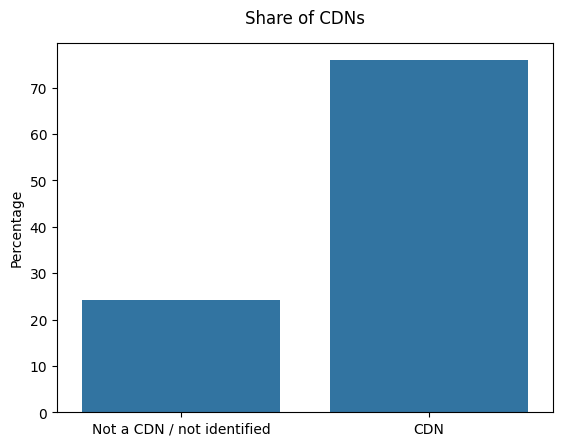

In [10]:
# Count the occurrences of the value "Not a CDN / not identified"
not_identified_count = (df['identified_via'] == 'Not a CDN / not identified').sum()

# Count the occurrences of all other values
identified_count = df.shape[0] - not_identified_count

# Calculate the percentages
total_count = df.shape[0]
not_identified_percentage = (not_identified_count / total_count) * 100
identified_percentage = (identified_count / total_count) * 100

# Create the bar chart
categories = ['Not a CDN / not identified', 'CDN']
percentages = [not_identified_percentage, identified_percentage]

sns.barplot(x=categories, y=percentages)
plt.ylabel('Percentage')
plt.xlabel('')
plt.title('Share of CDNs', y=1.03)
plt.show()

## Share of CDNs, differentiated by the way of identification

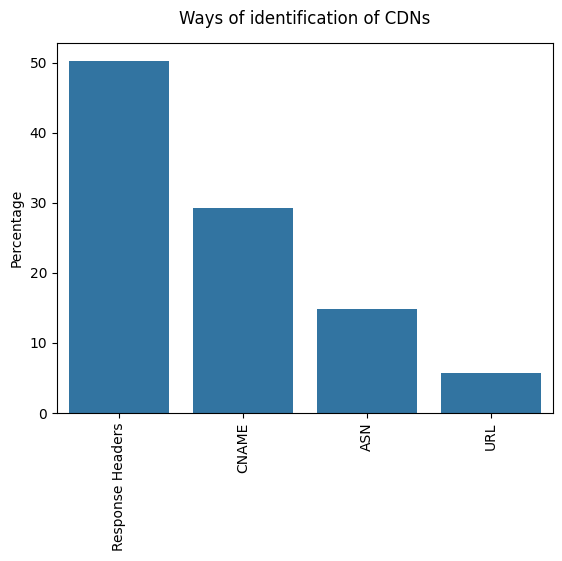

In [11]:
# Filter out not identified/non-CDNs
filtered_df = df[df['identified_via'] != 'Not a CDN / not identified']

# Count the occurrences of the individual values in the "identified_via" column
detected_by_counts = filtered_df['identified_via'].value_counts()

# Calculate the percentages
detected_by_percentages = detected_by_counts / detected_by_counts.sum() * 100

# Sort the values by frequency (already sorted by value_counts())
sorted_detected_by_percentages = detected_by_percentages.sort_values(ascending=False)

# Create bar chart
plt.xticks(rotation=90)
sns.barplot(x=sorted_detected_by_percentages.index, y=sorted_detected_by_percentages.values)
plt.ylabel('Percentage')
plt.xlabel('')
plt.title("Ways of identification of CDNs", y=1.03)
plt.show()

# Share of CDN providers

Calculate the share/percentage of the detected CDN providers

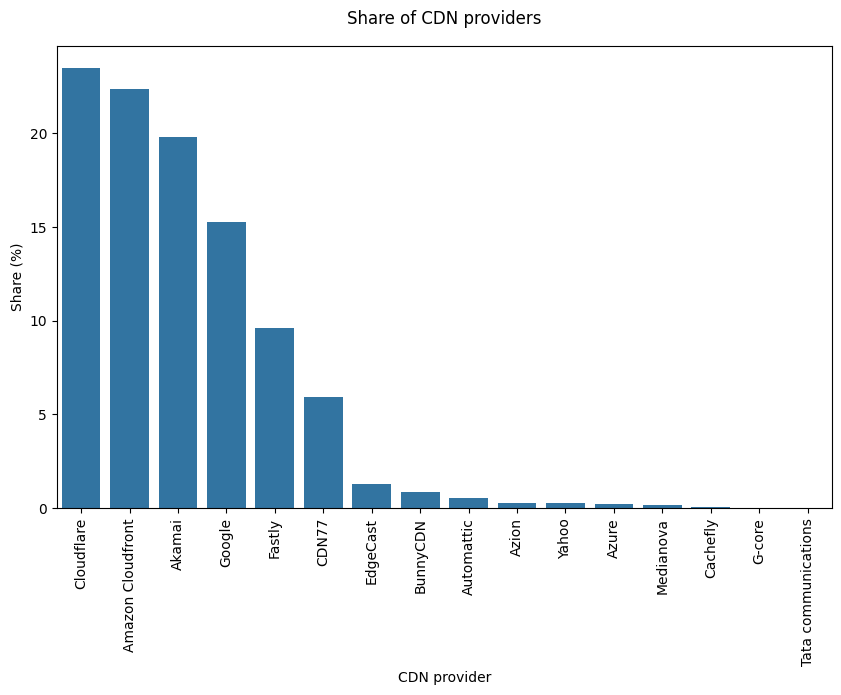

In [12]:
# Count the occurrences of the individual values in the "CDN" column
cdn_counts = df['CDN'].value_counts()
# Calculate the percentages
cdn_percentages = cdn_counts / cdn_counts.sum() * 100
# Sort the values by frequency (already sorted by value_counts())
sorted_cdn_percentages = cdn_percentages.sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x=sorted_cdn_percentages.index, y=sorted_cdn_percentages.values)
plt.ylabel('Share (%)')
plt.xlabel('CDN provider')
plt.title('Share of CDN providers', y=1.03)
plt.show()

## Expressed in number of requests
Showing the same data but with the actual numbers of requests instead of percentage.

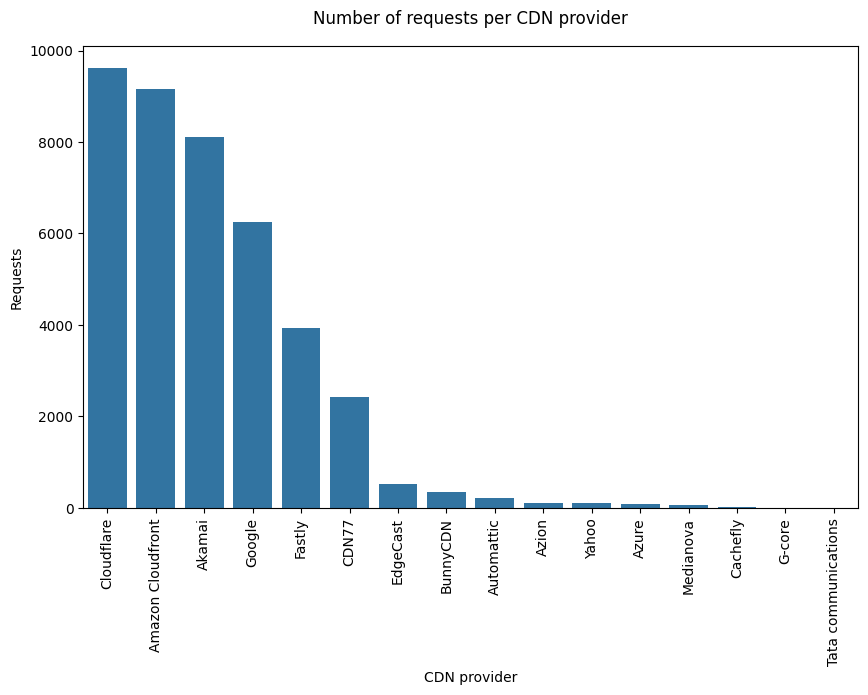

In [13]:
# Create bar chart
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(data=cdn_counts)
plt.ylabel('Requests')
plt.xlabel('CDN provider')
plt.title('Number of requests per CDN provider', y=1.03)
plt.show()